## Scaceship Competition 

On importe des bibiliothèques qui vont nous permettres de visualiser nos données

In [2]:
import numpy as np
import pandas as pd
import datetime
import multiprocessing
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import sys
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  RandomizedSearchCV, cross_val_predict, cross_val_score
from scipy.stats import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
train_data = pd.read_csv("data/train.csv")

## Exploration des données :

Afin d'explorer les données, on créer une fonction qui permet de calculer le ratio de survie en fonction d'une feature

In [4]:
def survival_rate(df,feature_name):
    group_count=df[[feature_name,'Transported']].groupby(feature_name).count().rename(columns={'Transported':'Passengers'})
    print(group_count)
    group_survived= df[[feature_name,'Transported']].groupby(feature_name).sum().rename(columns={'Transported':'Survived'})
    print(group_survived)
    final_df= group_count.merge(group_survived,how="left",left_index=True,right_index=True)
    final_df['Survival_rate']=final_df['Survived']/final_df['Passengers']
    final_df.drop(columns={'Passengers','Survived'},inplace=True)
    return final_df

In [5]:
survival_rate(train_data,"CryoSleep")

           Passengers
CryoSleep            
False            5439
True             3037
           Survived
CryoSleep          
False          1789
True           2483


,Survival_rate
CryoSleep,
False,0.328921
True,0.817583


           Passengers
CryoSleep            
False            5439
True             3037
           Survived
CryoSleep          
False          1789
True           2483
   CryoSleep  Survival_rate
0      False       0.328921
1       True       0.817583


<AxesSubplot:xlabel='CryoSleep', ylabel='Survival_rate'>

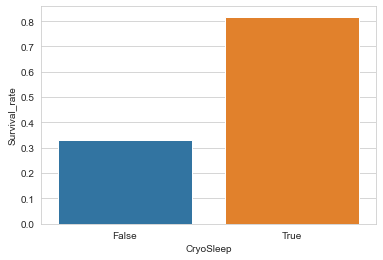

In [6]:
group_strength_survival_rate=survival_rate(train_data,'CryoSleep')
group_strength_survival_rate.reset_index(inplace=True)
print(group_strength_survival_rate)
sns.set_style("whitegrid")
sns.barplot(data=group_strength_survival_rate,x="CryoSleep",y="Survival_rate")

On remarque ici que 82% des passagers qui ont choisie de se faire cryogénisé on survécue contre 33% pour ceux qui n'ont pas fait ce choix

                    Passengers
Passenger_in_group            
1                         4805
2                         1682
3                         1020
4                          412
5                          265
6                          174
7                          231
8                          104
                    Survived
Passenger_in_group          
1                       2174
2                        905
3                        605
4                        264
5                        157
6                        107
7                        125
8                         41
   Passenger_in_group  Survival_rate
0                   1       0.452445
1                   2       0.538050
2                   3       0.593137
3                   4       0.640777
4                   5       0.592453
5                   6       0.614943
6                   7       0.541126
7                   8       0.394231


<AxesSubplot:xlabel='Passenger_in_group', ylabel='Survival_rate'>

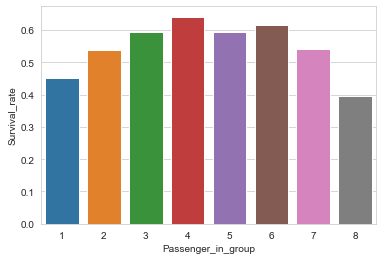

In [7]:
train_data["Group"]=train_data["PassengerId"].str.slice(stop=4)
#On prend les 4 premiers nombres de l'id qui représente le groupe de la personne

group_wise=train_data[['Group','PassengerId']].groupby(['Group']).count().rename(columns={"PassengerId":"Passenger_in_group"})
#ici group_wise représente le nombre de passager par groupe

train_data=pd.merge(train_data,group_wise,how="left",left_on="Group",right_index=True)
#on join group_wise à train_data

group_strength_survival_rate=survival_rate(train_data,'Passenger_in_group')
group_strength_survival_rate.reset_index(inplace=True)
print(group_strength_survival_rate)
sns.barplot(data=group_strength_survival_rate,x="Passenger_in_group",y="Survival_rate")
#on affiche le taux de survie en fonction du nombre de personne par groupe

On remarque une différence de taux de survie en fonction du nombre de personne par groupe : le taux de survie augmente pour un nombre de personnes entre 1 et 4 puis il baisse de 4 à 8 (nombre de personne maximum par groupe)

                    Passengers
Passenger_in_cabin            
1.0                       5427
2.0                       1372
3.0                        747
4.0                        416
5.0                        235
6.0                        198
7.0                         91
8.0                          8
                    Survived
Passenger_in_cabin          
1.0                     2418
2.0                      817
3.0                      457
4.0                      264
5.0                      142
6.0                      125
7.0                       52
8.0                        3
   Passenger_in_cabin  Survival_rate
0                 1.0       0.445550
1                 2.0       0.595481
2                 3.0       0.611780
3                 4.0       0.634615
4                 5.0       0.604255
5                 6.0       0.631313
6                 7.0       0.571429
7                 8.0       0.375000


<AxesSubplot:xlabel='Passenger_in_cabin', ylabel='Survival_rate'>

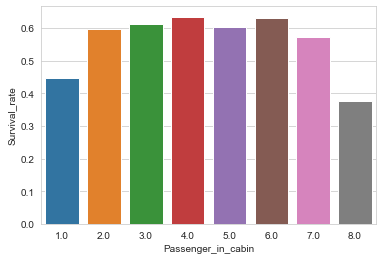

In [8]:
group_wise=train_data[['Cabin','PassengerId']].groupby(['Cabin']).count().rename(columns={"PassengerId":"Passenger_in_cabin"})
train_data=pd.merge(train_data,group_wise,how="left",left_on="Cabin",right_index=True)
group_strength_survival_rate=survival_rate(train_data,"Passenger_in_cabin")
group_strength_survival_rate.reset_index(inplace=True)
print(group_strength_survival_rate)
sns.barplot(data=group_strength_survival_rate,x="Passenger_in_cabin",y="Survival_rate")

In [9]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Passenger_in_group,Passenger_in_cabin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,2.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,2.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,1.0


Ici on fait le même constat que pour le nombre de personnes par groupe : le taux de survie augmente pour un nombre de personnes entre 1 et 4 puis il baisse de 4 à 8 (nombre de personne maximum par cabine)

On créer ensuite une colonne qui représente le total des dépenses pour chaque passager

In [8]:
train_data['Total_spend']=train_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
cut_labels_4 = ['0-10000','10001-20000','20001-30000','30001-40000']
cut_bins = [0, 10000, 20000, 30000, 40000]
train_data['cut_Total_spend'] = pd.cut(train_data['Total_spend'], bins=cut_bins, labels=cut_labels_4)
train_data[['cut_Total_spend','Total_spend']]

,cut_Total_spend,Total_spend
0,NaN,0.0
1,0-10000,736.0
2,10001-20000,10383.0
3,0-10000,5176.0
4,0-10000,1091.0
...,...,...
8688,0-10000,8536.0
8689,NaN,0.0
8690,0-10000,1873.0
8691,0-10000,4637.0


On affiche ensuite cela sous la forme d'un graph

In [9]:
total_spend_survice=survival_rate(train_data[train_data['CryoSleep']==False],'cut_Total_spend')

                 Passengers
cut_Total_spend            
0-10000                4742
10001-20000             148
20001-30000              27
30001-40000               4
                 Survived
cut_Total_spend          
0-10000              1416
10001-20000            47
20001-30000             5
30001-40000             2


In [10]:
total_spend_survice.reset_index(inplace=True)

<AxesSubplot:xlabel='cut_Total_spend', ylabel='Survival_rate'>

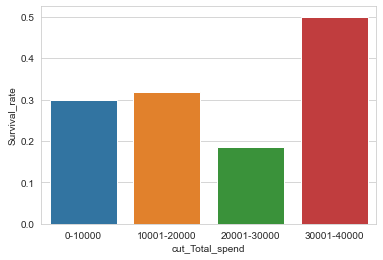

In [11]:
sns.barplot(data=total_spend_survice,x="cut_Total_spend",y="Survival_rate")

Il ne semble pas avoir de tendance uniforme, on remarque cependant que le taux de survie est très important pour les gens qui ont les plus dépensé 

On essaye de voir si le taux survie est différent pour les différents Decks et coté du vaisseau

      Passengers
Deck            
A            256
B            779
C            747
D            478
E            876
F           2794
G           2559
T              5
      Survived
Deck          
A          127
B          572
C          508
D          207
E          313
F         1229
G         1321
T            1


<AxesSubplot:xlabel='Deck', ylabel='Survival_rate'>

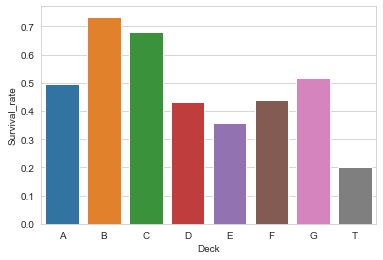

In [12]:
train_data['Deck']=train_data['Cabin'].str.split('/', expand=True)[0]
train_data['Side']=train_data['Cabin'].str.split('/', expand=True)[2]
deck_survival_rates=survival_rate(train_data,'Deck')
deck_survival_rates.reset_index(inplace=True)
sns.set_style("whitegrid")
sns.barplot(data=deck_survival_rates,x="Deck",y="Survival_rate")

On remarque le taux de survie change en focntion de la cabine

      Passengers
Side            
P           4206
S           4288
      Survived
Side          
P         1898
S         2380


<AxesSubplot:xlabel='Side', ylabel='Survival_rate'>

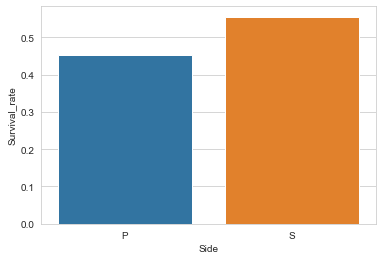

In [13]:
side_survival_rates=survival_rate(train_data,'Side')
side_survival_rates.reset_index(inplace=True)
sns.barplot(data=side_survival_rates,x="Side",y="Survival_rate")

In [14]:
survival_rate(train_data,'Side')

      Passengers
Side            
P           4206
S           4288
      Survived
Side          
P         1898
S         2380


,Survival_rate
Side,
P,0.451260
S,0.555037


Le taux de survie est plus élevé pour les passagers du coté S

**On essaye maintenant d'ameliorer la complétion des données :**

Les passagers du même groupe ont-ils la même homePlanet ?

In [15]:
#Create a dataframe containing
group_wise_passenger=train_data[['HomePlanet','Group']].groupby(['Group']).nunique()
group_wise_passenger.rename(columns={'HomePlanet':'Number_of_home_planets_ingroup'},inplace=True)
print("Nombre de groupe qui ont plus que une homePlanet :",group_wise_passenger[group_wise_passenger['Number_of_home_planets_ingroup']>1].shape[0])

Nombre de groupe qui ont plus que une homePlanet : 0


On remarque ici que tous les passagers d'un même groupe viennent de la même planet, on peut alors utiliser cette information afin de mieux compléter les homePlanet manquante

**On regarde si l'âge médian change en fonction de la homePlanet**

<AxesSubplot:xlabel='HomePlanet', ylabel='Median_age_planet'>

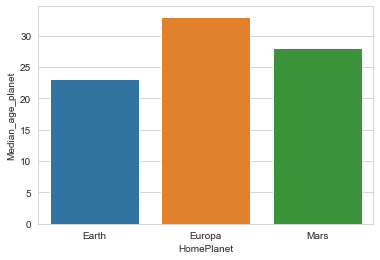

In [16]:
for_filling_age=train_data[['Age','HomePlanet']].groupby(['HomePlanet']).median()
for_filling_age.rename(columns={"Age":"Median_age_planet"},inplace=True)
for_filling_age.reset_index(inplace=True)
sns.barplot(data=for_filling_age,x="HomePlanet",y="Median_age_planet")

On remarque que l'âge moyen change en fonction de la planète d'origine, on pourras alors utiliser cette information afin de mieux compléter le champs âge.

**On créer maintenant des pipelines pour l'entrainement du modèle**

Ici on créer les nouvelles features et on remplace les valeurs manquantes :

In [17]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names   
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        return X.loc[:, self.feature_names].copy(deep=True)


class feature_maker(BaseEstimator, TransformerMixin):
    def __init__(self):

        pass
    def fit( self, X, y = None ):

        return self
# Function to create features and for impute features.
    def transform(self, a, y=None):
    #   Create features Deck, Side and Group from Cabin and PassengerId
        a.loc[:,'Deck'] = a['Cabin'].str.split('/', expand=True)[0]
        a.loc[:,'Side'] = a['Cabin'].str.split('/', expand=True)[2]
        a.loc[:,'Group'] = a['PassengerId'].str.split('_', 1, expand=True)[0].astype(int)
        
    #   Create feature to calculate number of Passengers in the Deck that the Passenger is travelling in     
        cabin_wise=a[['Cabin','Deck']].groupby(['Cabin']).count().rename(columns={"Deck":"Cabin_Passenger"})
        a=pd.merge(a,cabin_wise,how="left",left_on="Cabin",right_index=True)
        
    #   Create feature to calculate number of  Passengers in the Group that the Passenger is travelling in
        group_wise=a[['Group','PassengerId']].groupby(['Group']).count().rename(columns={"PassengerId":"Passenger_in_group"})
        a=pd.merge(a,group_wise,how="left",left_on="Group",right_index=True)
        
    #   Create feature to calculate total expense as the sum of expense incurred in RoomService, FoodCourt,ShoppingMall, Spa and VRDeck#
        a.loc[:,'TotalSpending'] = a[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
        
    #   Create feature to find the homeplanet the other passengers in the group belong to. This is done by first calculating groupwise passengers. In Groups where there are no passengers with Homeplanet, Nan is marked. Later      
        group_wise_passenger=a[['PassengerId','Group']].groupby(['Group']).count()
        group_wise_passenger.rename(columns={'PassengerId':'Passengers_in_group'},inplace=True)
        group_wise_mf_planet=a[['HomePlanet','Group']].groupby(['Group']).agg(lambda x: x.value_counts().index[0] if x.value_counts().size>0 else float("Nan"))
        a=pd.merge(a,group_wise_passenger,how='left',left_on='Group',right_index=True)
        group_wise_mf_planet.rename(columns={'HomePlanet':'Top_planet_in_group'},inplace=True)
        a=pd.merge(a,group_wise_mf_planet,how='left',left_on='Group',right_index=True)
        a.loc[(a['HomePlanet'].isna())&(a['Passengers_in_group']>1),'HomePlanet']=a[(a['HomePlanet'].isna())&(a['Passengers_in_group']>1)]['Top_planet_in_group']
        
    #   Create a dataframe for HomePlanet wise median age and use it to impute age where it is missing  
        for_filling_age=a[['Age','HomePlanet']].groupby(['HomePlanet']).median()
        for_filling_age.rename(columns={"Age":"Median_age_planet"},inplace=True)
        a=pd.merge(a,for_filling_age,how="left",left_on="HomePlanet",right_index=True)
        a.loc[(~ a['HomePlanet'].isna())&(a['Age'].isna()),'Age']=a[(~a['HomePlanet'].isna())&(a['Age'].isna())]['Median_age_planet']
        a.drop(columns=['Top_planet_in_group', 'Median_age_planet','Passengers_in_group'],inplace=True)
        a.drop(columns=['Cabin','PassengerId'],inplace=True)

        return a
daily_trend_feature_pipeline = Pipeline(steps = [ 
    ("selector", FeatureSelector(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])),
    ("feature_engineering", feature_maker()),])

**on créer un transformer et une pipeline**

In [18]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='median')),
        ("scale", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformers', numeric_transformer, ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpending','Cabin_Passenger','Passenger_in_group']),
        ('categorical_transformers', categorical_transformer, ['HomePlanet', 'CryoSleep','Destination','VIP','Deck','Side']),
    ])
feature_pipeline = Pipeline(
    steps=[
        ("daily_trend_feature_pipeline", daily_trend_feature_pipeline),
        ("otherpipeline",preprocessor)
        
    ])

Une fois la pipeline effedctuée on va tester différent modèle pour voir ce qui fonctionne le mieux

On test avec une logistic regression :

Accuracy of Logistic Regression is as follows:  0.787646152596401


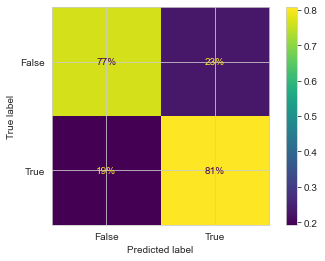

In [19]:
y_train = train_data['Transported']
X_train = train_data.drop(columns={'Name','Transported'})
# print(X_train.shape)
data = feature_pipeline.fit_transform(X_train)
# print(data.shape)
log_reg = Pipeline([
    ("Preprocessing", feature_pipeline),
    ("model", LogisticRegression(random_state = 42))
])

#cm_log = confusion_matrix(y_train, y_pred)
LogisticReg_acc = cross_val_score(log_reg, X_train, y_train, cv = 3, scoring = "accuracy",error_score='raise').mean()

print("Accuracy of Logistic Regression is as follows: ", LogisticReg_acc)

y_pred = cross_val_predict(log_reg, X_train, y_train, cv = 3)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize = "true", values_format = ".0%")
plt.show()

avec une random forest : 

Accuracy of Random Forest is as  0.7768326689699624


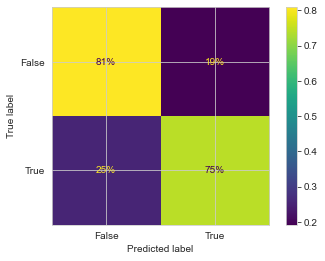

In [20]:
random_forest = Pipeline([
    ("Preprocessing", feature_pipeline),
    ("model", RandomForestClassifier(random_state = 42))
])

RandomForest_acc = cross_val_score(random_forest, X_train, y_train, cv = 3, scoring = "accuracy").mean()

print("Accuracy of Random Forest is as ", RandomForest_acc)

y_pred = cross_val_predict(random_forest, X_train, y_train, cv = 3)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize = "true", values_format = ".0%")

avec le Support Vector Machine 

Accuracy of Support Vector Machine:  0.7925940378102285


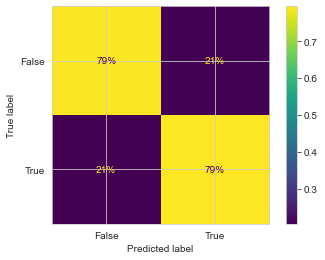

In [21]:
svc_clf = Pipeline([
    ("Preprocessing", feature_pipeline),
    ("model", SVC(random_state = 42))
])

SVC_acc = cross_val_score(svc_clf, X_train, y_train, cv = 3, scoring = "accuracy").mean()

print("Accuracy of Support Vector Machine: ", SVC_acc)

y_pred = cross_val_predict(svc_clf, X_train, y_train, cv = 3)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize = "true", values_format = ".0%")

On trouve que le meilleur modèle est le SVM on va donc chercher les meilleurs paramètres

In [22]:
X_test = pd.read_csv("data/test.csv")
param_distr = {'model__C':randint(low = 1, high = 100),
              'model__degree': randint(low = 1, high = 20),
              'model__coef0':randint(low = 1, high = 100)}
rnd = RandomizedSearchCV(svc_clf,param_distributions = param_distr, cv = 3, n_iter = 10,
                         scoring = "accuracy", random_state = 42)
rnd.fit(X_train, y_train)
model = rnd.best_estimator_
prediction = model.predict(X_test)
sub = pd.DataFrame({
        "PassengerId": X_test.PassengerId,
        "Transported": prediction})
sub.to_csv('submission.csv', index=False)